# Distortion Classification

In [13]:
import torch
from torch import nn
import torchaudio
import os
import numpy as np
import matplotlib.pyplot as plt

### Load dataset

In [14]:
from src.gtfxdataset import GtFxDataset

AUDIO_DIR = "_assets/DATASET/GT-FX-ALL/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        "reverb")

signal, _, _, _, _ = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")
    

Using device cpu
There are 87696 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])


#### Split dataset into train and test sets

In [15]:
from src.classifier import train

BATCH_SIZE = 128

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)


#### Model training

In [16]:
from src.classifier import model

LEARNING_RATE = 0.0005
EPOCHS = 10

WEIGHTS_DIR = "_weights/"
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, "c53_classify_rv.pth")

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# construct model and assign it to device
cnn = model.SingleClassifier().to(device)

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            EPOCHS,
            mode="single")

# save model
torch.save(cnn.state_dict(), WEIGHTS_FILE)
print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

Epoch 1
loss: 0.918062  [  0/70272]
loss: 0.278454  [2560/70272]
loss: 0.346868  [5120/70272]
loss: 0.234915  [7680/70272]
loss: 0.159298  [10240/70272]
loss: 0.079659  [12800/70272]
loss: 0.043303  [15360/70272]
loss: 0.063775  [17920/70272]
loss: 0.069707  [20480/70272]
loss: 0.064606  [23040/70272]
loss: 0.031189  [25600/70272]
loss: 0.021223  [28160/70272]
loss: 0.020848  [30720/70272]
loss: 0.032120  [33280/70272]
loss: 0.037330  [35840/70272]


KeyboardInterrupt: 

#### Evaluation

Accuracy: 99.0%, avg loss: 0.042642

[[ 97   3]
 [  3 523]]


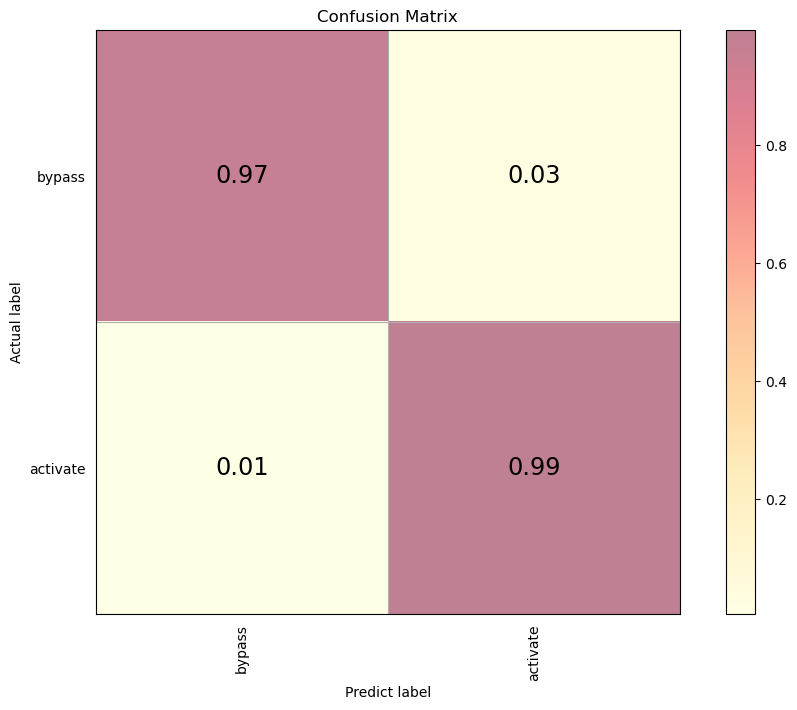

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.99      0.99      0.99       526

    accuracy                           0.99       626
   macro avg       0.98      0.98      0.98       626
weighted avg       0.99      0.99      0.99       626



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix

labels_ID = ['bypass', 'activate']

cnn = model.SingleClassifier().to(device)

state_dict = torch.load(WEIGHTS_FILE)
cnn.load_state_dict(state_dict)

log = train.test(cnn, val_dataloader, device, mode="single")

expected = []
predicted = []
for index, data in enumerate(log):
    predicted.append(data[1])
    expected.append(data[2])

mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
print(mat_con)
plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID)

print(classification_report(expected, predicted))
